# Логистическая регрессия и проблема XOR

XOR - это логическая операция, которая возвращает 1, если аргументы не равны, и 0 в обратном случае. Если мы изобразим случайные данные разных классов по принципу XOR, то увидим, что линейно их никак не разделить. 

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
%matplotlib inline

In [2]:
data = pd.read_csv('boston_crime.csv', sep=',')

def shoot_nans(value):
    if value == 'Y':
        return 1
    if pd.isnull(value):
        return 0

for col in ['SHOOTING']:
    data[col] = data[col].apply(shoot_nans)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411033 entries, 0 to 411032
Data columns (total 17 columns):
INCIDENT_NUMBER        411033 non-null object
OFFENSE_CODE           411033 non-null int64
OFFENSE_CODE_GROUP     411033 non-null object
OFFENSE_DESCRIPTION    411033 non-null object
DISTRICT               408902 non-null object
REPORTING_AREA         411033 non-null object
SHOOTING               411033 non-null int64
OCCURRED_ON_DATE       411033 non-null object
YEAR                   411033 non-null int64
MONTH                  411033 non-null int64
DAY_OF_WEEK            411033 non-null object
HOUR                   411033 non-null int64
UCR_PART               410924 non-null object
STREET                 398927 non-null object
Lat                    384797 non-null float64
Long                   384797 non-null float64
Location               411033 non-null object
dtypes: float64(2), int64(5), object(10)
memory usage: 53.3+ MB


In [3]:
def dropper(X):
    if 'STREET' in X.columns:
        X = X.drop(['INCIDENT_NUMBER', 'REPORTING_AREA', 'OFFENSE_CODE_GROUP','YEAR', 'MONTH', 'HOUR', 'UCR_PART',
                     'OFFENSE_DESCRIPTION', 'STREET', 'OFFENSE_CODE'],
                     axis='columns')
    return X

In [4]:
def other_transformations(X):
    def dig(s):
        n = ['1','2','3','4','5','6','7','8','9','0']
        if pd.isnull(s):
            return 0
        else:            
            s_int = ''
            for i in range(len(s)):
                if s[i] in n:
                    s_int += s[i]
        return int(s_int)

    def distr_nans(value):
        sec = {
            'A': 1,
            'B': 2,
            'C': 3,
            'D': 4,
            'E': 5,
        }
        if pd.isnull(value):
            return 0
        else: 
            if isinstance(value, str):
                return sec[value[0]]

    def loc_nans(value):
        if pd.isnull(value):
            return 0
        else:
            return value*1000000

    def week (value):
        weekdays = {
            'Monday' : 1,
            'Tuesday' : 2,
            'Wednesday' : 3, 
            'Thursday' : 4, 
            'Friday' : 5, 
            'Saturday' : 6, 
            'Sunday' : 7
        }
        return weekdays[value]
    
    def datef (value):
        return pd.Timestamp(ts_input = value).timestamp()
    
    if 'DISTRICT' in X.columns:
        for col in ['DISTRICT']:
            X['Location'] = X[col].apply(dig)
            X[col]=X[col].apply(distr_nans)
    if 'OCCURRED_ON_DATE' in X.columns:
        for col in ['OCCURRED_ON_DATE']:
            X[col]=X[col].apply(datef)
    if 'Lat' in X.columns:        
        for col in ['Lat', 'Long']:
            X[col]=X[col].apply(loc_nans)
    #if 'SHOOTING' in X.columns:
    #    for col in ['SHOOTING']:
    #        X[col] = X[col].apply(shoot_nans)
    if 'DAY_OF_WEEK' in X.columns:
        X['DAY_OF_WEEK'] = X['DAY_OF_WEEK'].apply(week)
    return X

data = other_transformations(dropper(data))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411033 entries, 0 to 411032
Data columns (total 7 columns):
DISTRICT            411033 non-null int64
SHOOTING            411033 non-null int64
OCCURRED_ON_DATE    411033 non-null float64
DAY_OF_WEEK         411033 non-null int64
Lat                 411033 non-null float64
Long                411033 non-null float64
Location            411033 non-null int64
dtypes: float64(3), int64(4)
memory usage: 22.0 MB


In [16]:
X = data.drop('SHOOTING', axis='columns')
y = data['SHOOTING']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size = 0.33, stratify=y)

In [6]:
def norm(X_train, X_test, y_train):
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
    X_train_scaled.reset_index(inplace=True, drop=True)
    y_train.reset_index(drop=True, inplace=True)
    dead = X_train_scaled[y_train == 1]
    for i in range (7):
        dead = pd.concat([dead,dead], ignore_index=True)
    X_train_strat = pd.concat([X_train_scaled, dead], ignore_index=True)
    y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                              ignore_index=True)
    return X_train_strat, X_test_scaled, y_train_strat

In [17]:
X_train, X_test, y_train = norm(X_train, X_test, y_train)

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420032 entries, 0 to 420031
Data columns (total 6 columns):
DISTRICT            420032 non-null float64
OCCURRED_ON_DATE    420032 non-null float64
DAY_OF_WEEK         420032 non-null float64
Lat                 420032 non-null float64
Long                420032 non-null float64
Location            420032 non-null float64
dtypes: float64(6)
memory usage: 19.2 MB


In [19]:
y_train.value_counts()
#y_test.value_counts()

0.0    274262
1.0    145770
dtype: int64

In [ ]:
classifier = LogisticRegression('l1', C=2, max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)
a = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))            
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

In [ ]:
classifier = LogisticRegression('l1', C=6, max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)
a = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc


print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))            
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

In [ ]:
classifier = LogisticRegression('l1', C=0.6, max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)
a = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc


print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))            
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Видим, что работает так себе. Что если на вход подать не $x_1$ и $x_2$, а некоторые их полиномы?
Преобразуем текущие признаки в 6 других: $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
new_classifier = Pipeline([('poly', PolynomialFeatures(degree=7)), ('logit', LogisticRegression())])
new_classifier.fit(X, y)
# Обучите новый классификатор на тех же данных и посмотрим, как он себя ведет в исходном пространстве признаков.

In [ ]:
new_classifier.score(X_test, y_test)

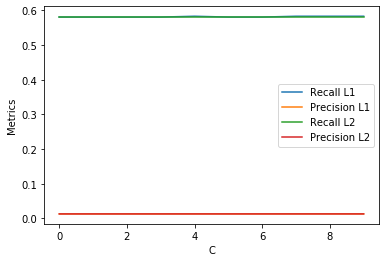

In [43]:
recall1 = {}
precision1 = {}
recall2 = {}
precision2 = {}
i = 0
for n in range(10, 60, 5):
    clf = LogisticRegression('l1', C=n/100, max_iter = 10000, solver = 'liblinear')
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    b = clf.predict(X_test)
    precision1[i] = precision_score(y_test, b)
    recall1[i] = recall_score(y_test, b)
    i += 1
i = 0
for n in range(10, 60, 5):
    clf = LogisticRegression('l2', C=n/100, max_iter = 10000, solver = 'liblinear')
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    b = clf.predict(X_test)
    precision2[i] = precision_score(y_test, b)
    recall2[i] = recall_score(y_test, b)
    i += 1
# нарисуем графики
plt.plot(list(recall1.keys()), list(recall1.values()), label='Recall L1')
plt.plot(list(precision1.keys()), list(precision1.values()), label='Precision L1')
plt.plot(list(recall2.keys()), list(recall2.values()), label='Recall L2')
plt.plot(list(precision2.keys()), list(precision2.values()), label='Precision L2')
plt.xlabel('C')
plt.ylabel('Metrics')
plt.legend()
plt.show()

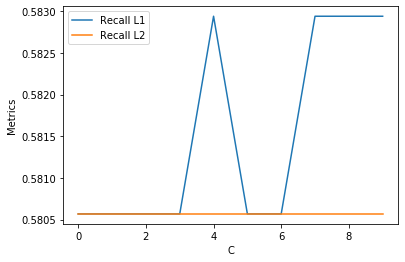

In [44]:
recall11={}
recall22={}
for i in range(len(recall1)):
    recall11[i]=recall1[i]
for i in range(len(recall2)):
    recall22[i]=recall2[i]
plt.plot(list(recall11.keys()), list(recall11.values()), label='Recall L1')
plt.plot(list(recall22.keys()), list(recall22.values()), label='Recall L2')
plt.xlabel('C')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [45]:
print(list(recall1.values()))

[0.580568720379147, 0.580568720379147, 0.580568720379147, 0.580568720379147, 0.5829383886255924, 0.580568720379147, 0.580568720379147, 0.5829383886255924, 0.5829383886255924, 0.5829383886255924]


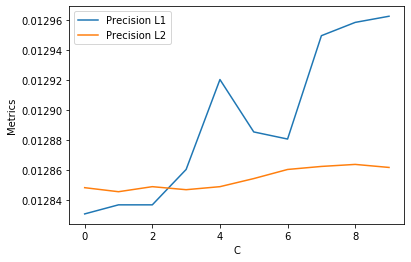

In [49]:
precision11={}
precision22={}
for i in range(len(precision1)):
    precision11[i]=precision1[i]
for i in range(len(precision2)):
    precision22[i]=precision2[i]
plt.plot(list(precision11.keys()), list(precision11.values()), label='Precision L1')
plt.plot(list(precision22.keys()), list(precision22.values()), label='Precision L2')
plt.xlabel('C')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [48]:
print(list(precision1.values()))

[0.012830583922492799, 0.012836634182123023, 0.012836634182123023, 0.012860217311427221, 0.01292016806722689, 0.012885242452929421, 0.012880500499447979, 0.012949413065220825, 0.012958280657395701, 0.012962377489724945]


Исходя из полученных результатов, принимается С = 0.55. Посмотрим на веса признаков при L1-регуляризации:

In [25]:
classifier = LogisticRegression('l1', C=0.55, max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=0.55, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
classifier.coef_

array([[-3.20999686e-01, -3.20508168e-02,  6.88069331e-01,
        -5.99956061e+01, -5.95124293e+01, -6.48389888e-01]])

In [27]:
classifier = LogisticRegression('l2', C=0.55,  max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=0.55, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
classifier.coef_

array([[-0.26860539, -0.03573228,  0.69357983, -5.59960862, -6.28206006,
        -0.65058368]])

In [23]:
classifier = LogisticRegression('l1', C=10,  max_iter = 10000, solver = 'liblinear')
classifier.fit(X_train, y_train)
a = classifier.predict(X_test)
print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))            
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.9921557641126209
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49811970240959397
PRC AUC: 0.0020495277976423057
F1: 0.0
F0.5: 0.0
F2: 0.0


In [24]:
classifier.coef_

array([[-3.48301112e-01, -3.17793812e-02,  6.86772883e-01,
        -8.25184450e+01, -8.15390248e+01, -6.46690317e-01]])